In [ ]:
import keras
import os
import tensorflow as tf
import time

os.environ["KERAS_BACKEND"] = "tensorflow"
device_name = tf.test.gpu_device_name()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting seed for reproducability
np.random.seed(1234)
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

### Обработка данных

In [ ]:
# Data ingestion - reading the datasets from Azure blob
!wget http://azuremlsamples.azureml.net/templatedata/PM_train.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_test.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_truth.txt

--2023-10-17 16:31:41--  http://azuremlsamples.azureml.net/templatedata/PM_train.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.70, 13.107.213.70, 2620:1ec:bdf::70, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3515356 (3.4M) [text/plain]
Saving to: ‘PM_train.txt’

PM_train.txt        100%[===================>]   3.35M  --.-KB/s    in 0.1s    

2023-10-17 16:31:41 (31.7 MB/s) - ‘PM_train.txt’ saved [3515356/3515356]

--2023-10-17 16:31:41--  http://azuremlsamples.azureml.net/templatedata/PM_test.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.70, 13.107.213.70, 2620:1ec:bdf::70, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2228855 (2.1M) [text/plain]
Saving to: ‘PM_test.txt’

PM_test.txt

In [ ]:
# read training data
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [ ]:
# read test data
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [ ]:
# read ground truth data
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [ ]:
train_df = train_df.sort_values(['id','cycle'])
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [ ]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [ ]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [ ]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [ ]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


In [ ]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [ ]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [ ]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


In [ ]:
# pick a large window size of 50 cycles
sequence_length = 50

In [ ]:
# preparing data for visualizations
# интервал в 50 циклов до точки отказа для идентификатора двигателя 
engine_id20 = test_df[test_df['id'] == 20]
engine_id20_50cycleWindow = engine_id20[engine_id20['RUL'] <= engine_id20['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id20_50cycleWindow1 = engine_id20_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id20_50cycleWindow2 = engine_id20_50cycleWindow[cols2]

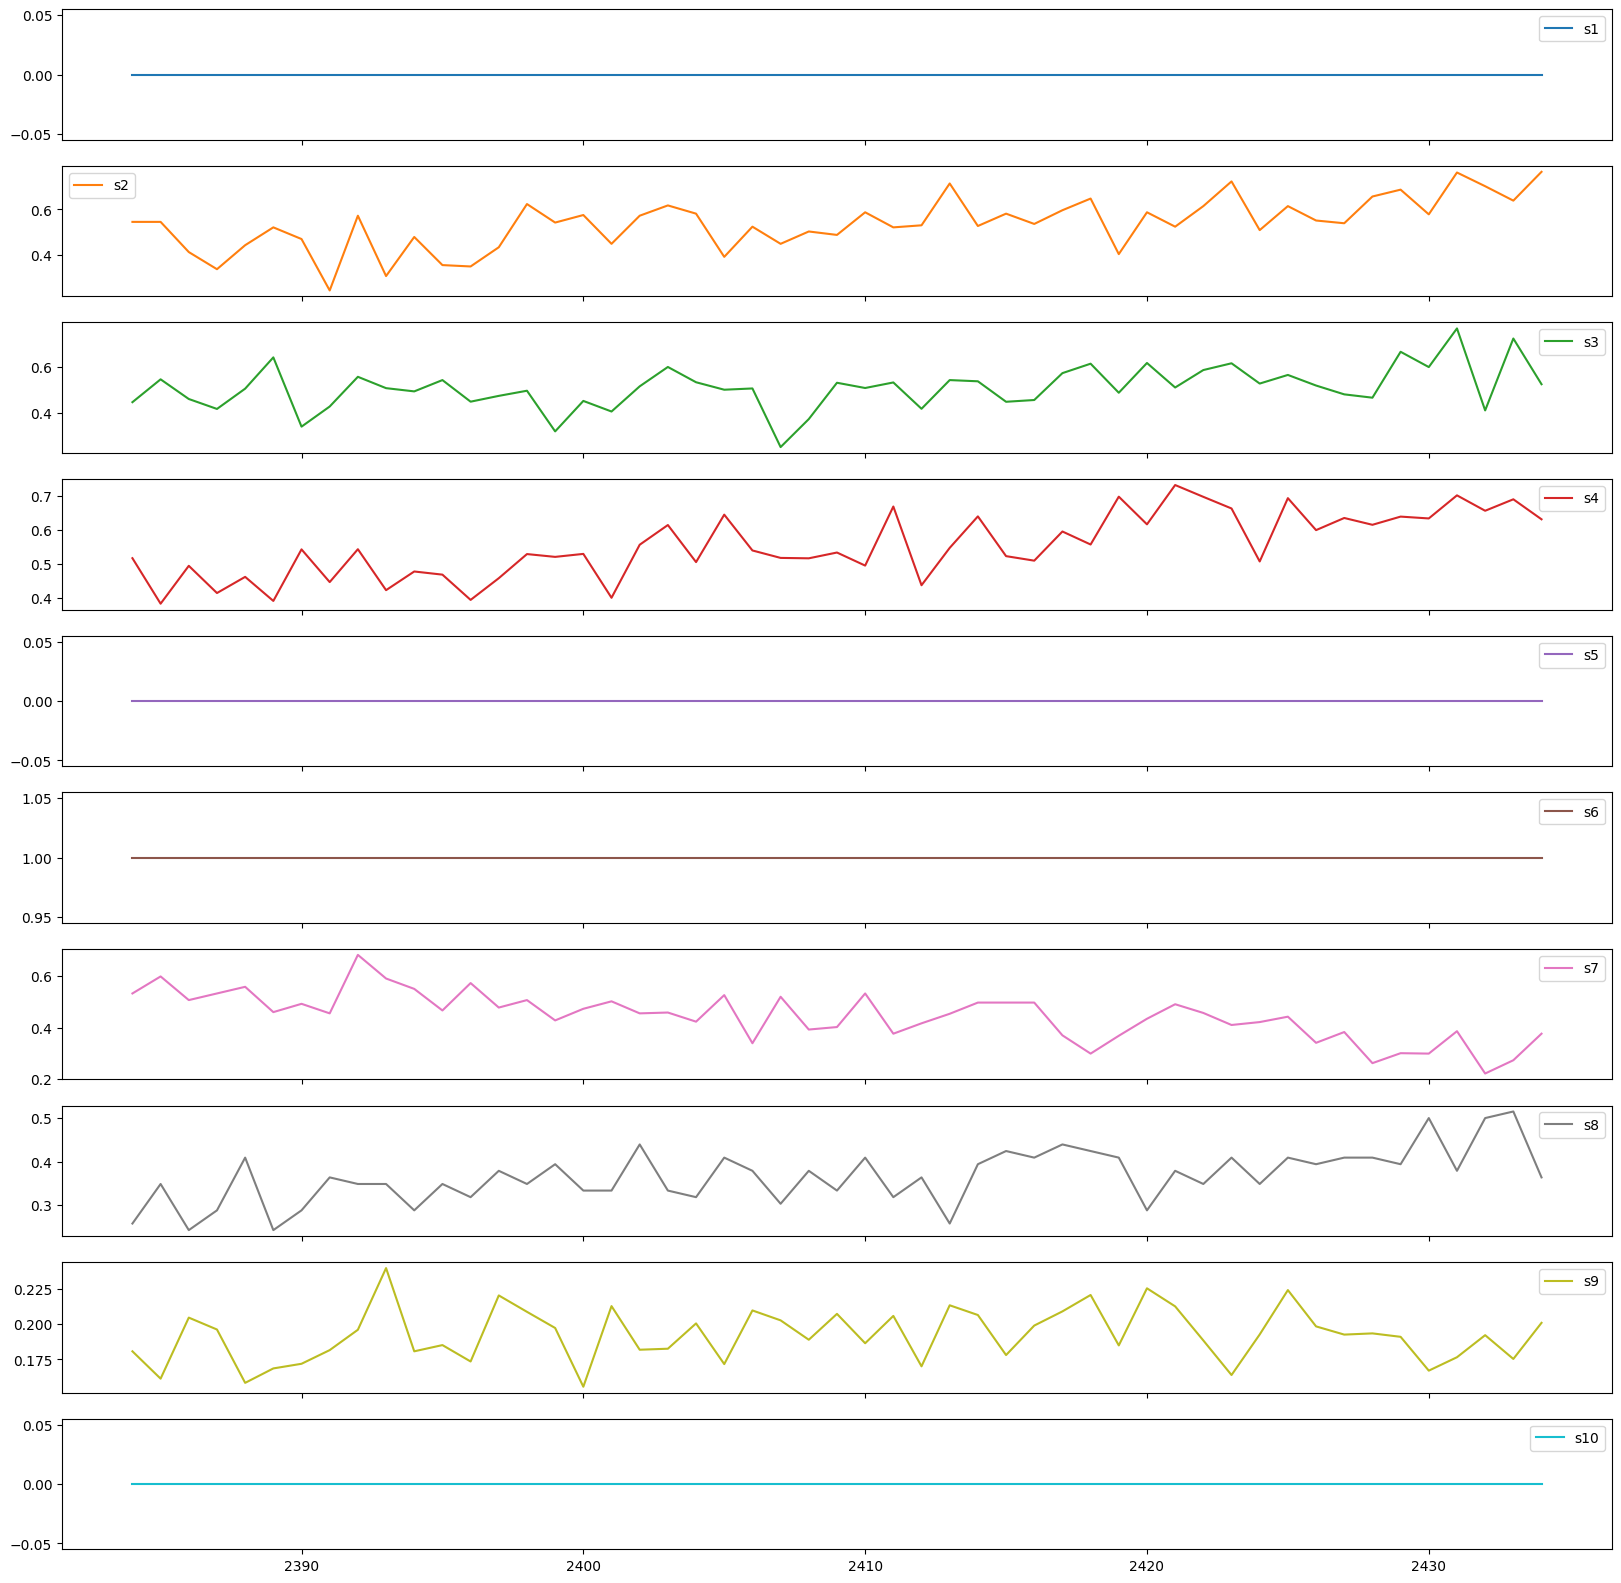

In [ ]:
ax1 = engine_id20_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

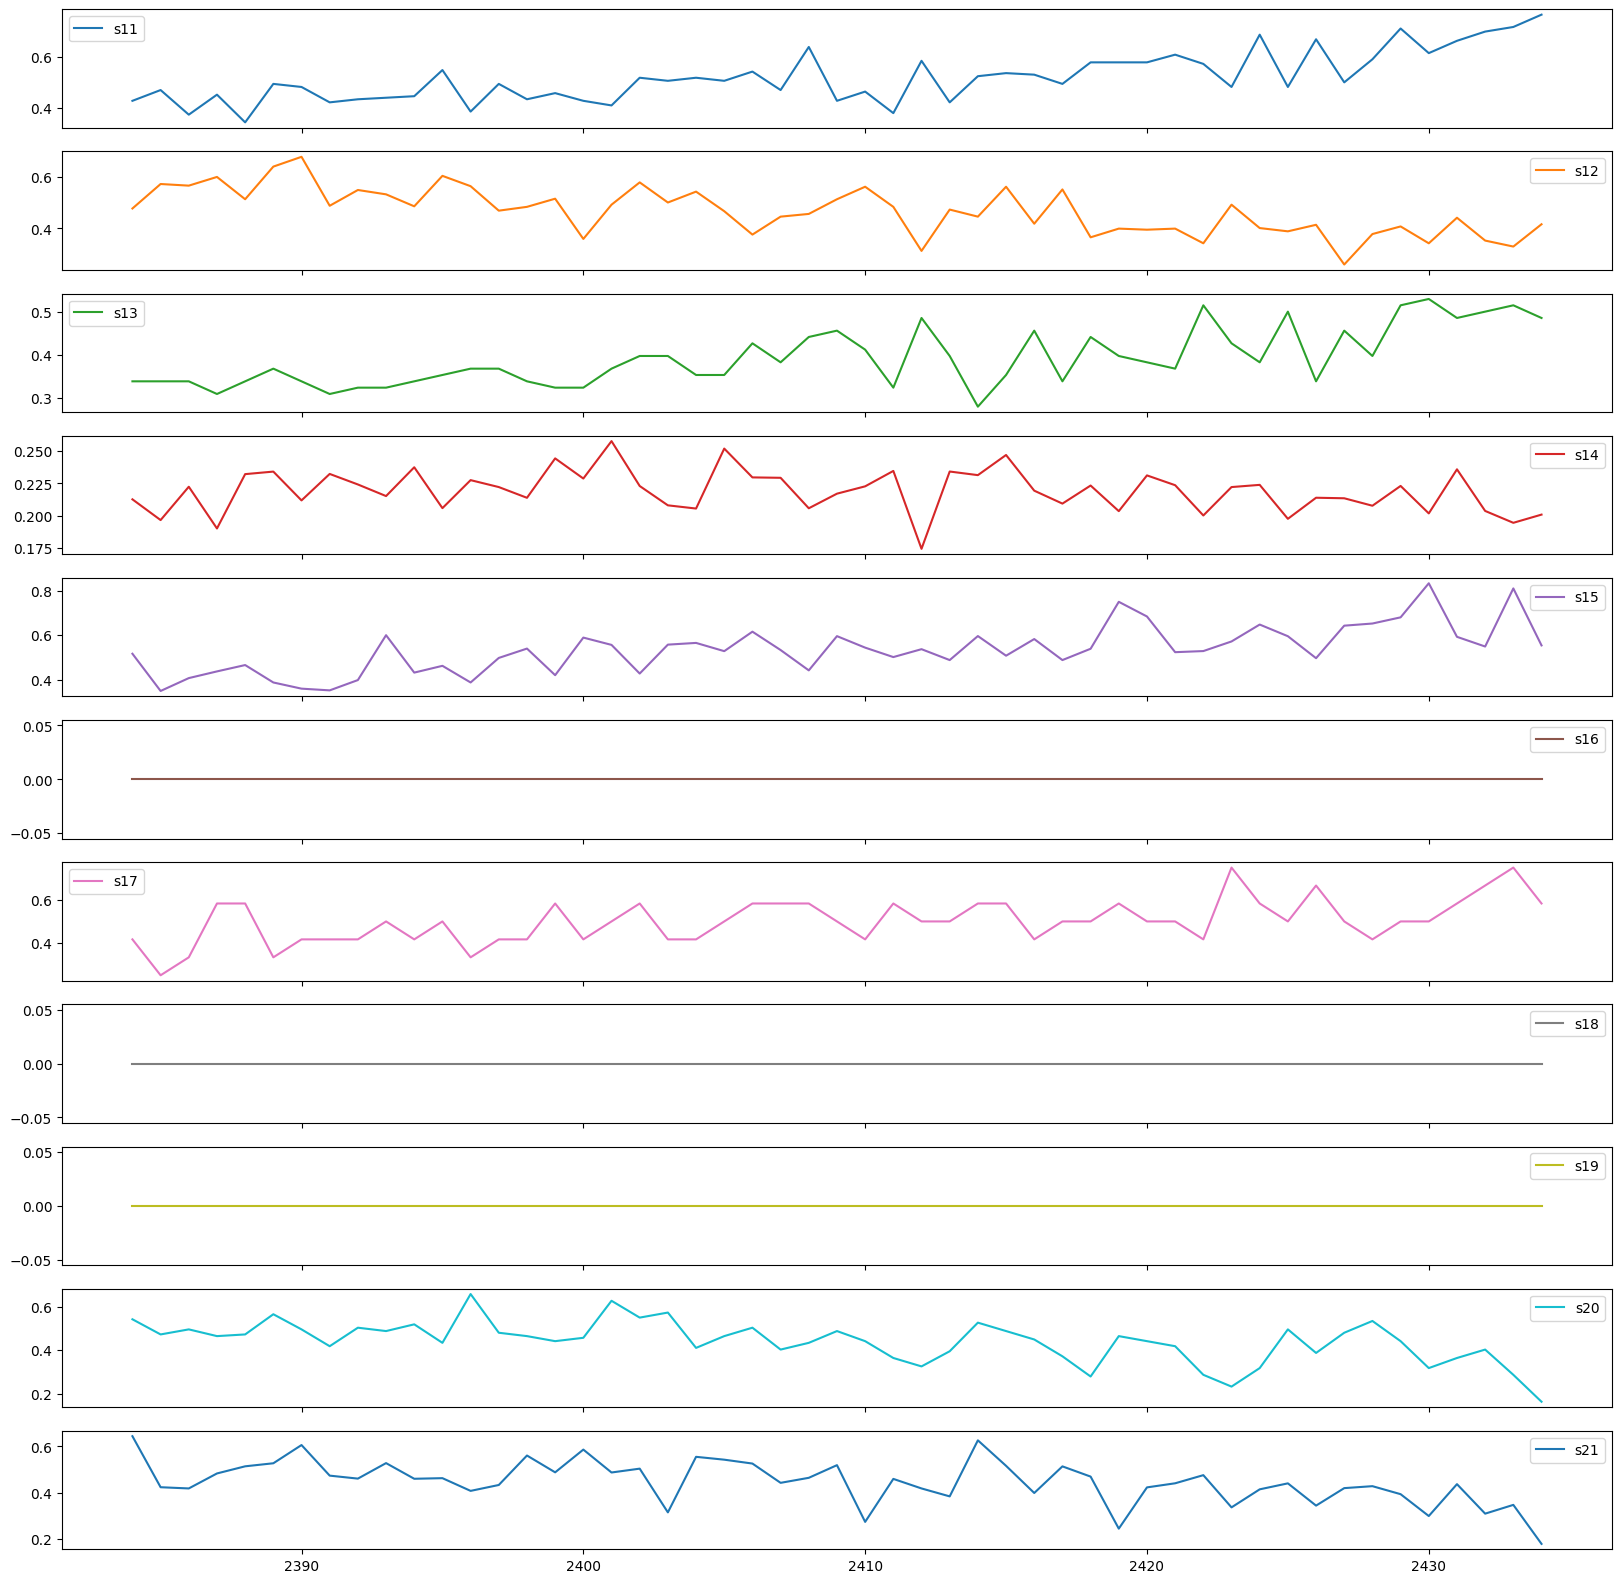

In [ ]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 11-21
ax2 = engine_id20_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

In [ ]:
# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [ ]:
# pick the feature columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [ ]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols))
           for id in train_df['id'].unique())

In [ ]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

In [ ]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [ ]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1'])
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

### LSTM

In [ ]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

modelLSTM = Sequential()

modelLSTM.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
modelLSTM.add(Dropout(0.2))

modelLSTM.add(LSTM(
          units=50,
          return_sequences=False))
modelLSTM.add(Dropout(0.2))

modelLSTM.add(Dense(units=nb_out, activation='sigmoid'))
modelLSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print(modelLSTM.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 80651 (315.04 KB)
Trainable params: 80651 (315.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
def plot_history(history: tf.keras.callbacks.History):
    plt.figure(figsize=(10, 5))

    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')

    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')

    plt.legend(loc='upper right', bbox_to_anchor=(1.27, 1),
               fancybox=True, shadow=True)
    plt.xlabel('Epochs')
    plt.xticks(list(range(len(history.history['loss']))))
    plt.ylabel('Loss and accuracy')
    plt.show()

In [ ]:
%%time
# fit the network
start_time = time.time()
history = modelLSTM.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
end_time = time.time() - start_time
if device_name != '/device:GPU:0':
  lstm_train_time_cpu = end_time
else:
  lstm_train_time_gpu = end_time

Epoch 1/10
75/75 [==============================] - 10s 23ms/step - loss: 0.2413 - accuracy: 0.8955 - val_loss: 0.0829 - val_accuracy: 0.9655
Epoch 2/10
75/75 [==============================] - 1s 9ms/step - loss: 0.1040 - accuracy: 0.9580 - val_loss: 0.0555 - val_accuracy: 0.9783
Epoch 3/10
75/75 [==============================] - 1s 11ms/step - loss: 0.0804 - accuracy: 0.9669 - val_loss: 0.0467 - val_accuracy: 0.9783
Epoch 4/10
75/75 [==============================] - 1s 13ms/step - loss: 0.0696 - accuracy: 0.9713 - val_loss: 0.0629 - val_accuracy: 0.9706
CPU times: user 9.18 s, sys: 820 ms, total: 10 s
Wall time: 13.2 s


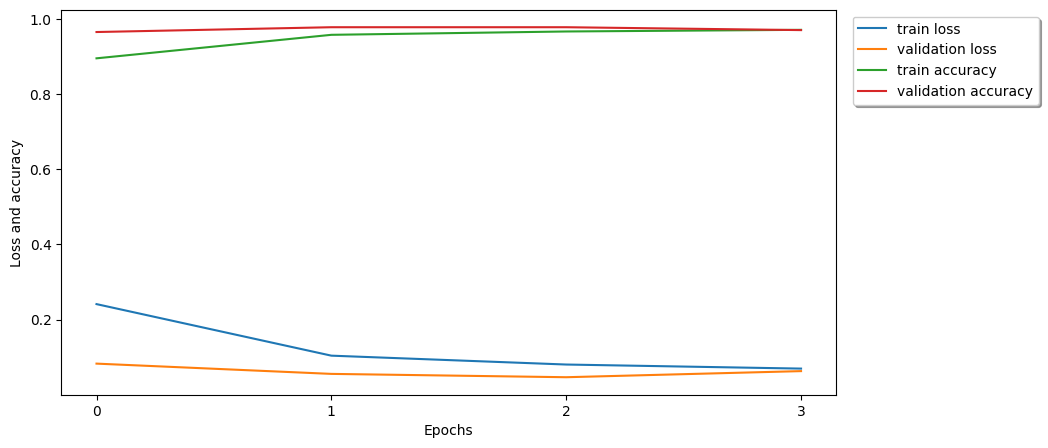

In [ ]:
plot_history(history)

In [ ]:
# training metrics
scores = modelLSTM.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 0s 5ms/step - loss: 0.0831 - accuracy: 0.9658
Accurracy: 0.9657731652259827


In [ ]:
# make predictions and compute confusion matrix
y_pred = np.round(modelLSTM.predict(seq_array,verbose=1, batch_size=200))
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 1s 4ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12509,    22],
       [  513,  2587]])

In [ ]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9915676504407819 
 recall =  0.834516129032258


In [ ]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [ ]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [ ]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [ ]:
# test metrics
scores_test = modelLSTM.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.1523 - accuracy: 0.9355 - 31ms/epoch - 10ms/step
Accurracy: 0.9354838728904724


In [ ]:
# make predictions and compute confusion matrix
y_pred_test = np.round(modelLSTM.predict(seq_array_test_last))
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

3/3 [==============================] - 0s 5ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[68,  0],
       [ 6, 19]])

In [ ]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  1.0 
 Recall:  0.76 
 F1-score: 0.8636363636363636


In [ ]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM'])
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.935484,1.0,0.76,0.863636


### GRU

In [ ]:
from keras.layers import GRU

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=100, return_sequences=True, input_shape=(sequence_length, nb_features)))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=100, return_sequences=True, input_shape=(sequence_length, nb_features)))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=nb_out, activation='sigmoid'))
# Compiling the RNN
regressorGRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print(regressorGRU.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 100)           38100     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 gru_1 (GRU)                 (None, 50, 100)           60600     
                                                                 
 dropout_3 (Dropout)         (None, 50, 100)           0         
                                                                 
 dense_1 (Dense)             (None, 50, 1)             101       
                                                                 
Total params: 98801 (385.94 KB)
Trainable params: 98801 (385.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
%%time
# fit the network
start_time = time.time()
history = regressorGRU.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
end_time = time.time() - start_time
if device_name != '/device:GPU:0':
  gru_train_time_cpu = end_time
else:
  gru_train_time_gpu = end_time

Epoch 1/10
75/75 [==============================] - 6s 21ms/step - loss: 0.3446 - accuracy: 0.8482 - val_loss: 0.3022 - val_accuracy: 0.8552
Epoch 2/10
75/75 [==============================] - 1s 12ms/step - loss: 0.2614 - accuracy: 0.8866 - val_loss: 0.3114 - val_accuracy: 0.8693
CPU times: user 6.94 s, sys: 278 ms, total: 7.22 s
Wall time: 6.88 s


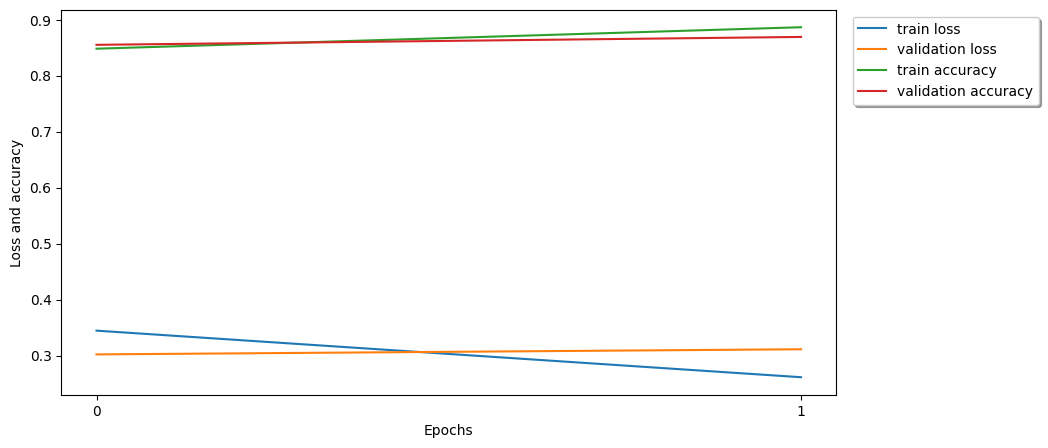

In [ ]:
plot_history(history)

In [ ]:
# training metrics
scores = regressorGRU.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 1s 8ms/step - loss: 0.2804 - accuracy: 0.8751
Accurracy: 0.8750853538513184


In [ ]:
# make predictions and compute confusion matrix
y_pred = np.argmax(regressorGRU.predict(seq_array,verbose=1, batch_size=200),axis=1)
y_pred[y_pred!=0] = 1
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 1s 6ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[11270,  1261],
       [  313,  2787]])

In [ ]:
# compute precision and recall
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.8993026677755742 
 recall =  0.8993026677755742


In [ ]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [ ]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [ ]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [ ]:
# test metrics
scores_test = regressorGRU.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.4935 - accuracy: 0.7822 - 32ms/epoch - 11ms/step
Accurracy: 0.7821506261825562


In [ ]:
# make predictions and compute confusion matrix
y_pred_test = np.argmax(regressorGRU.predict(seq_array_test_last),axis=1)
y_pred_test[y_pred_test!=0] = 1
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

3/3 [==============================] - 0s 5ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[66,  2],
       [ 3, 22]])

In [ ]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test, average='micro')
recall_test = recall_score(y_true_test, y_pred_test, average='micro')
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.946236559139785 
 Recall:  0.946236559139785 
 F1-score: 0.946236559139785


In [ ]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['regressorGRU'])
results_df

,Accuracy,Precision,Recall,F1-score
regressorGRU,0.782151,0.946237,0.946237,0.946237


### RNN

In [ ]:
from keras.layers import SimpleRNN

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]


model = Sequential()

model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.2))

model.add(Dense(nb_out, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 100)           12600     
                                                                 
 dropout_4 (Dropout)         (None, 50, 100)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 100)           20100     
                                                                 
 dropout_5 (Dropout)         (None, 50, 100)           0         
                                                                 
 dense_2 (Dense)             (None, 50, 1)             101       
                                                                 
Total params: 32801 (128.13 KB)
Trainable params: 32801 (128.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
%%time
# fit the network
start_time = time.time()
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
end_time = time.time() - start_time
if device_name != '/device:GPU:0':
  rnn_train_time_cpu = end_time
else:
  rnn_train_time_gpu = end_time

Epoch 1/10
75/75 [==============================] - 10s 103ms/step - loss: 0.3370 - accuracy: 0.8528 - val_loss: 0.2635 - val_accuracy: 0.8791
Epoch 2/10
75/75 [==============================] - 6s 83ms/step - loss: 0.2424 - accuracy: 0.8972 - val_loss: 0.2214 - val_accuracy: 0.9092
Epoch 3/10
75/75 [==============================] - 8s 102ms/step - loss: 0.2355 - accuracy: 0.8997 - val_loss: 0.2172 - val_accuracy: 0.8995
Epoch 4/10
75/75 [==============================] - 6s 82ms/step - loss: 0.2160 - accuracy: 0.9070 - val_loss: 0.1862 - val_accuracy: 0.9218
Epoch 5/10
75/75 [==============================] - 8s 101ms/step - loss: 0.2038 - accuracy: 0.9115 - val_loss: 0.2029 - val_accuracy: 0.9085
CPU times: user 49.9 s, sys: 4.7 s, total: 54.6 s
Wall time: 38 s


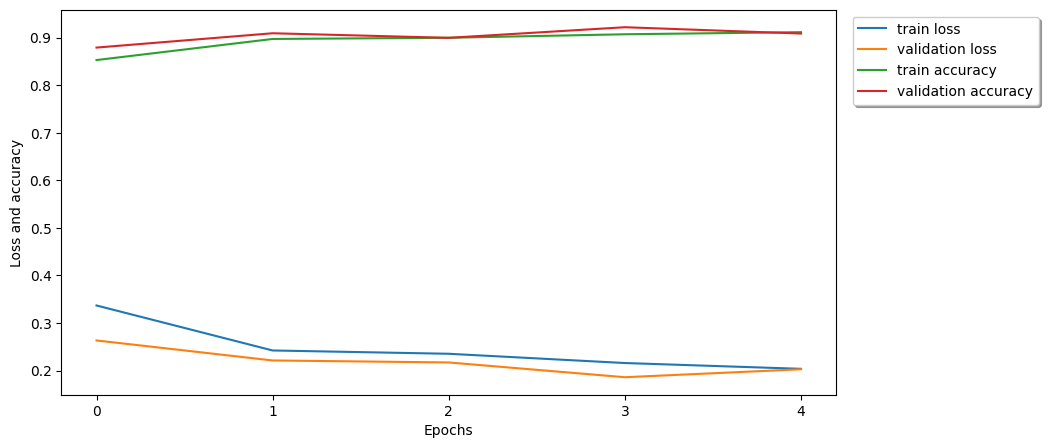

In [ ]:
plot_history(history)

In [ ]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 1s 11ms/step - loss: 0.2233 - accuracy: 0.9032
Accurracy: 0.9032090306282043


In [ ]:
# make predictions and compute confusion matrix
y_pred = np.argmax(model.predict(seq_array,verbose=1, batch_size=200),axis=1)
y_pred[y_pred!=0] = 1
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 2s 16ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[8770, 3761],
       [   1, 3099]])

In [ ]:
# compute precision and recall
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.7593244194229416 
 recall =  0.7593244194229416


In [ ]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [ ]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [ ]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [ ]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.3347 - accuracy: 0.8768 - 48ms/epoch - 16ms/step
Accurracy: 0.8767741322517395


In [ ]:
# make predictions and compute confusion matrix
y_pred_test = np.argmax(model.predict(seq_array_test_last),axis=1)
y_pred_test[y_pred_test!=0] = 1
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

3/3 [==============================] - 0s 10ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[50, 18],
       [ 0, 25]])

In [ ]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test, average='micro')
recall_test = recall_score(y_true_test, y_pred_test, average='micro')
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.8064516129032258 
 Recall:  0.8064516129032258 
 F1-score: 0.8064516129032258


In [ ]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['RNN'])
results_df

,Accuracy,Precision,Recall,F1-score
RNN,0.876774,0.806452,0.806452,0.806452


In [ ]:
print(lstm_train_time_cpu, gru_train_time_cpu, rnn_train_time_cpu)

73.1226155757904 108.44425058364868 30.855249404907227


In [ ]:
print(lstm_train_time_gpu, gru_train_time_gpu, rnn_train_time_gpu)

13.208141326904297 6.8832032680511475 37.95850872993469


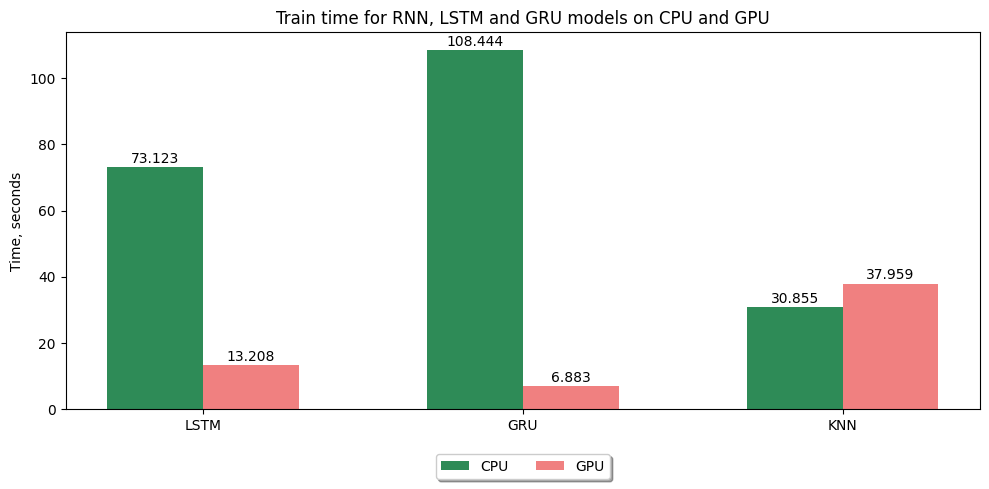

In [ ]:
labels = ['LSTM', "GRU", 'RNN']
cpu_times = [73.1226155757904, 108.44425058364868, 30.855249404907227]
gpu_times = [lstm_train_time_gpu, gru_train_time_gpu, rnn_train_time_gpu]

a = "seagreen"
b = "lightcoral"

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()

fig.set_size_inches(10, 5)

cpu_bar = ax.bar(x-width/2, np.round(cpu_times, 3), width, label='CPU', color=a)
gpu_bar = ax.bar(x+width/2, np.round(gpu_times, 3), width, label='GPU', color=b)

ax.set_ylabel('Time, seconds')
ax.set_title('Train time for RNN, LSTM and GRU models on CPU and GPU')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
        fancybox=True, shadow=True, ncol=2)

ax.bar_label(cpu_bar, padding=1)
ax.bar_label(gpu_bar, padding=1)

fig.tight_layout()

plt.show()